In [19]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
data = pd.read_csv('flights.csv') 
data, train_loader, val_loader, test_loader = get_data_loaders(data, 24, 10)
features = getFeatures()

<Axes: >

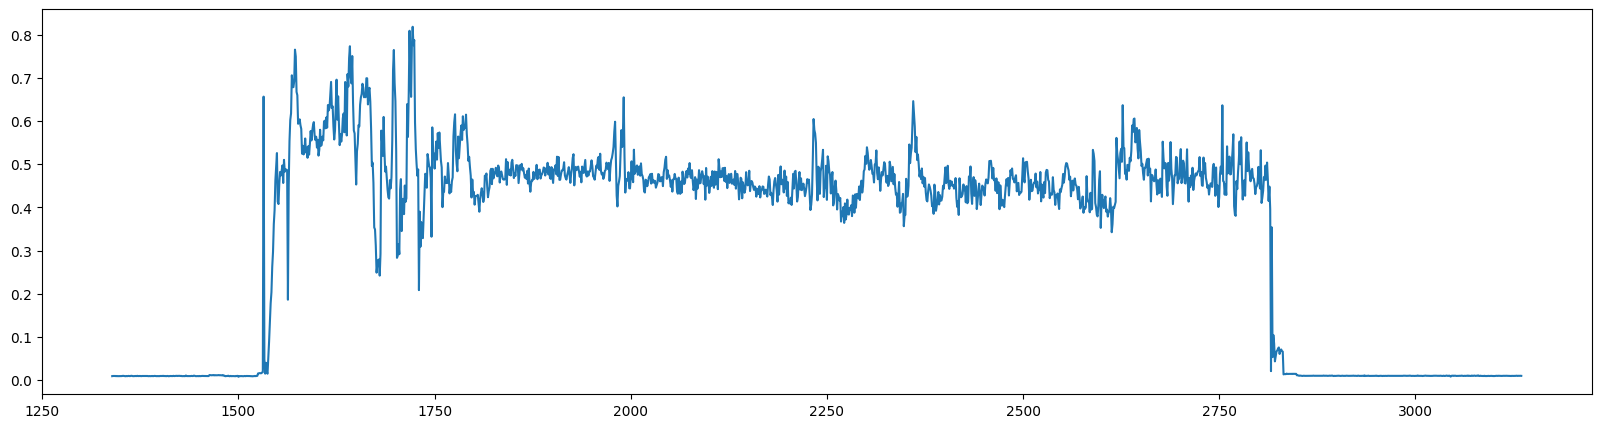

In [21]:
data[data['flight']==2]['power'].plot(figsize=(20, 5))

In [22]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 24, 35])
torch.Size([64, 10])


In [23]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)

        outputs = []
        for _ in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            output = self.fc(output) 
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(x)
        xt = x[:, -1, :].unsqueeze(1) # input the last time step of x into the decoder
        outputs = self.decoder(xt, h, c) # (batch_size, output_len, 1)
        return outputs

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(features)
input_len = 24
output_len = 10
hidden_size = 32  
num_layers = 1

# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [64,64,64,64], hidden_size, num_layers=num_layers).to(device)

cpu


In [24]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.001)

# Training loop with validation and early stopping
num_epochs = 1
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.4f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.4f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_best_model_{input_len}-{output_len}.pt')


Epoch 1/1 [TRAIN]: 100%|██████████| 2414/2414 [03:20<00:00, 12.05it/s, train_loss=0.00381]


Epoch 1/1, Average Training Loss: 0.0028


Epoch 1/1 [VAL]: 100%|██████████| 811/811 [00:38<00:00, 20.81it/s, val_loss=9.53e-5] 

Epoch 1/1, Average Validation Loss: 0.0029


Test loss: 0.002703306498005986
MAPE: 37.50775909423828


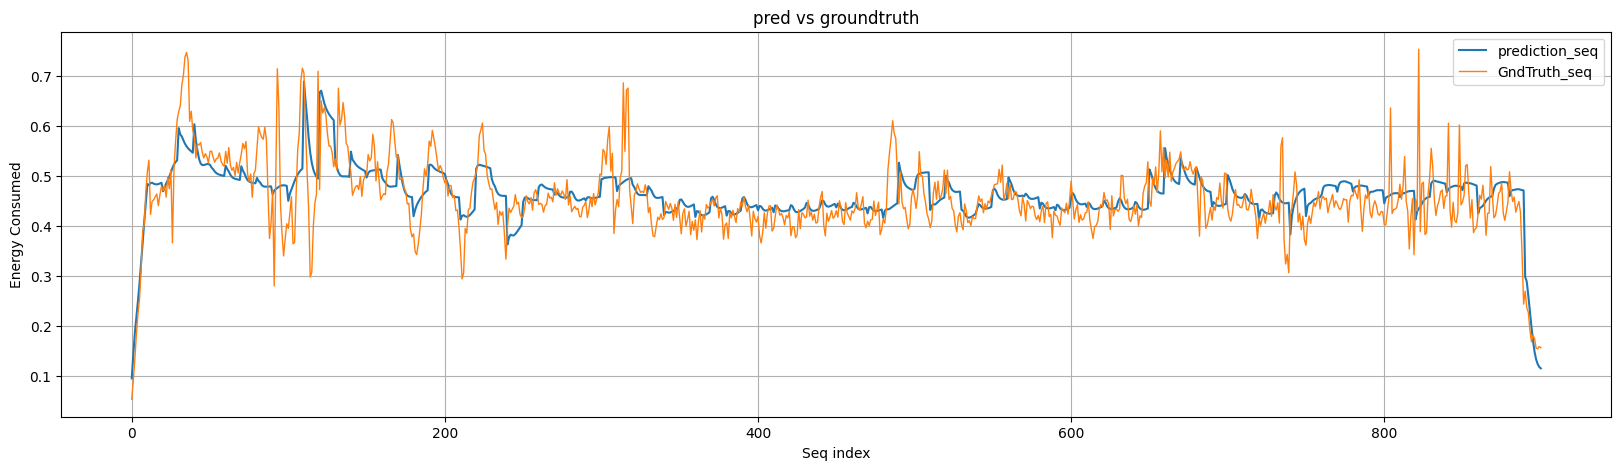

In [26]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load('TCN_LSTM_best_model_24-10.pt'))

# Test the model
seq2seq.eval()
# flight_num = random.randint(0, 100)
flight_num = 3
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[features].values, 
                                         test_data['power'].values,24,10)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data --Done

2. Debug invalid data when specifying the flight number -- No problem on my end?

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?  --DONE

4. Decoder input (i.e., future trajectory as inputs)  --Done, added features {x_future, y_future, z_future}

"""